In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cmocean.cm as cmo
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax

from jaxparrow.cyclogeostrophy import _fixed_point, _minimization_based
from jaxparrow.geostrophy import _geostrophy
from jaxparrow.utils import geometry, kinematics, operators, sanitize


jax.config.update("jax_enable_x64", True)

For validation purpose we consider an idealized circular and axisymmetric eddy as analytical solutions can be derived in that setting using the gradient wind equation.

The gaussian eddy we consider is of the form $\eta = -\eta_0 \exp^{-(r/R_0)^2}$, with $R_0$ its radius, $\eta_0$ the SSH anomaly at its center, and $r$ the radial distance. 
We choose to use a constant spatial step in meters.

In [3]:
R0 = 50e3
ETA0 = -.2
LAT0 = 36

dxy = 5e3

## Simulating the eddy

In [4]:
def simulate_gaussian_ssh(R0, eta0, r):
    return eta0 * jnp.exp(-(r / R0)**2)


def simulate_gaussian_geos(R0, X, Y, ssh, coriolis_factor):
    def f():
        return 2 * geometry.GRAVITY * ssh / (coriolis_factor * R0 ** 2)
    u_geos = Y * f()
    v_geos = -X * f()
    return u_geos, v_geos


def simulate_gaussian_cyclo(R0, X, Y, r, ssh, coriolis_factor):
    azim_geos = -(2 * geometry.GRAVITY * r * ssh / (coriolis_factor * R0 ** 2))
    azim_cyclo = 2 * azim_geos / (1 + jnp.sqrt(1 + 4 * azim_geos / (coriolis_factor * r)))
    u_cyclo = -azim_cyclo * Y / r
    v_cyclo = azim_cyclo * X / r
    return u_cyclo, v_cyclo


def simulate_gaussian_eddy(R0, dxy, eta0, latitude):
    l0 = R0 * 2  # limit boundary impact
    xy = jnp.arange(0, l0, dxy)
    xy = jnp.concatenate((-xy[::-1][:-1], xy))
    X, Y = jnp.meshgrid(xy, xy)
    R = jnp.hypot(X, Y)
    dXY = jnp.ones_like(X) * dxy
    coriolis_factor = jnp.ones_like(R) * geometry.compute_coriolis_factor(latitude)

    ssh = simulate_gaussian_ssh(R0, eta0, R)
    u_geos_t, v_geos_t = simulate_gaussian_geos(R0, X, Y, ssh, coriolis_factor)
    u_cyclo_t, v_cyclo_t = simulate_gaussian_cyclo(R0, X, Y, R, ssh, coriolis_factor)

    mask = jax.numpy.full_like(ssh, 0, dtype=bool)

    return X, Y, R, dXY, coriolis_factor, ssh, u_geos_t, v_geos_t, u_cyclo_t, v_cyclo_t, mask


X, Y, R, dXY, coriolis_factor, ssh, u_geos_t, v_geos_t, u_cyclo_t, v_cyclo_t, mask = simulate_gaussian_eddy(
    R0, dxy, ETA0, LAT0
)

We just make sure that the grids are correct.

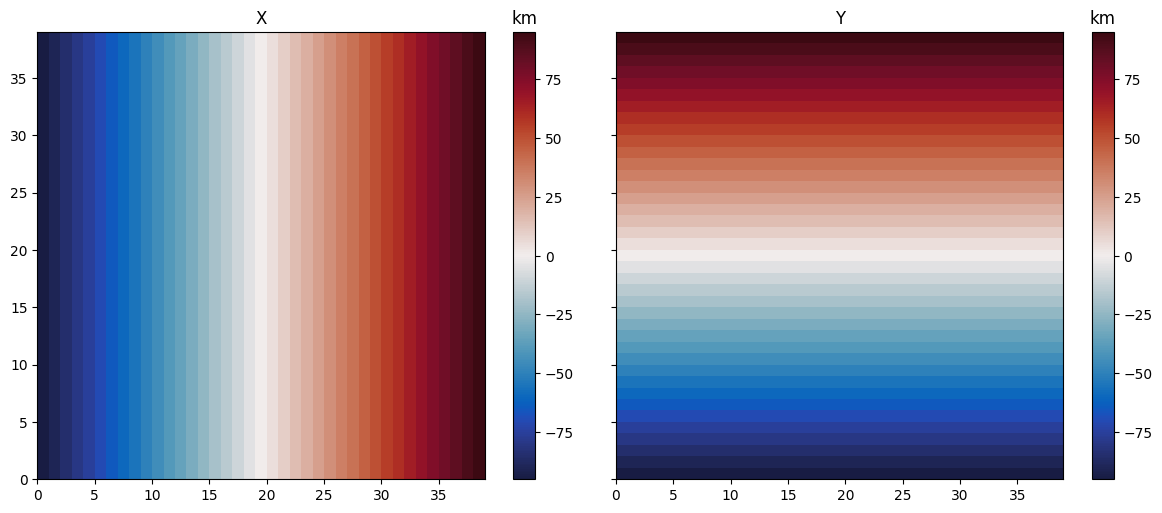

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

ax1.set_title("X")
im = ax1.pcolormesh(X / 1e3, cmap=cmo.balance)
ax1.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_title("km")

ax2.set_title("Y")
im = ax2.pcolormesh(Y / 1e3, cmap=cmo.balance)
ax2.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax2)
cbar.ax.set_title("km")

fig.tight_layout()

plt.show()

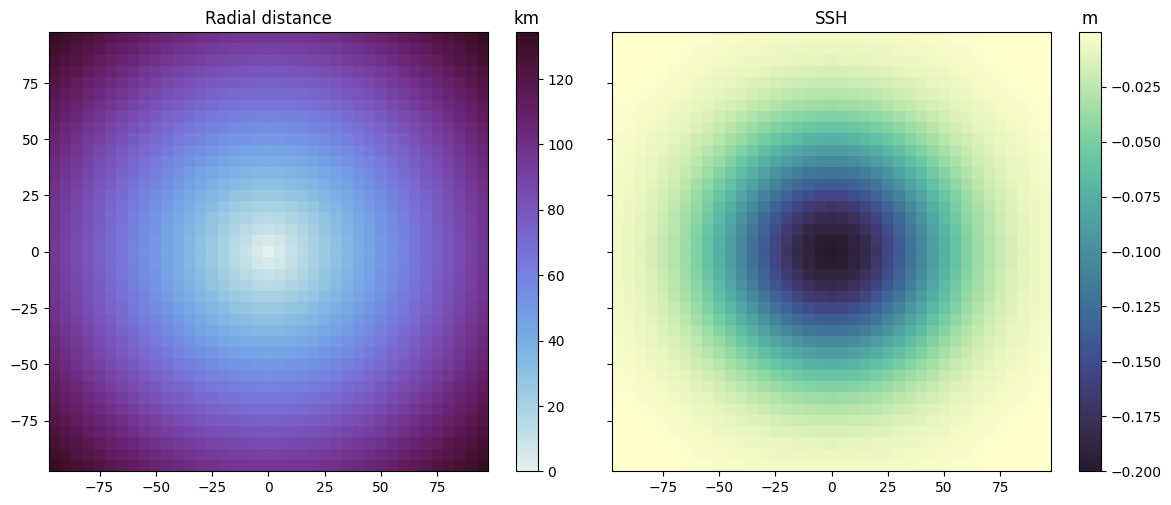

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

ax1.set_title("Radial distance")
im = ax1.pcolormesh(X / 1e3, Y / 1e3, R / 1e3, cmap=cmo.dense)
ax1.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_title("km")

ax2.set_title("SSH")
im = ax2.pcolormesh(X / 1e3, Y / 1e3, ssh, cmap=cmo.deep_r)
ax2.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax2)
cbar.ax.set_title("m")

fig.tight_layout()

plt.show()

## Geostrophy

### Analytical solution

$u_g = 2y \frac{g \eta_0}{f R_0^2} \exp^{-(r/R_0)^2} = 2y \frac{g \eta}{f R_0^2}$

$v_g = -2x \frac{g \eta_0}{f R_0^2} \exp^{-(r/R_0)^2} = -2x \frac{g \eta}{f R_0^2}$

In [7]:
uv_geos = kinematics.magnitude(u_geos_t, v_geos_t, interpolate=False)

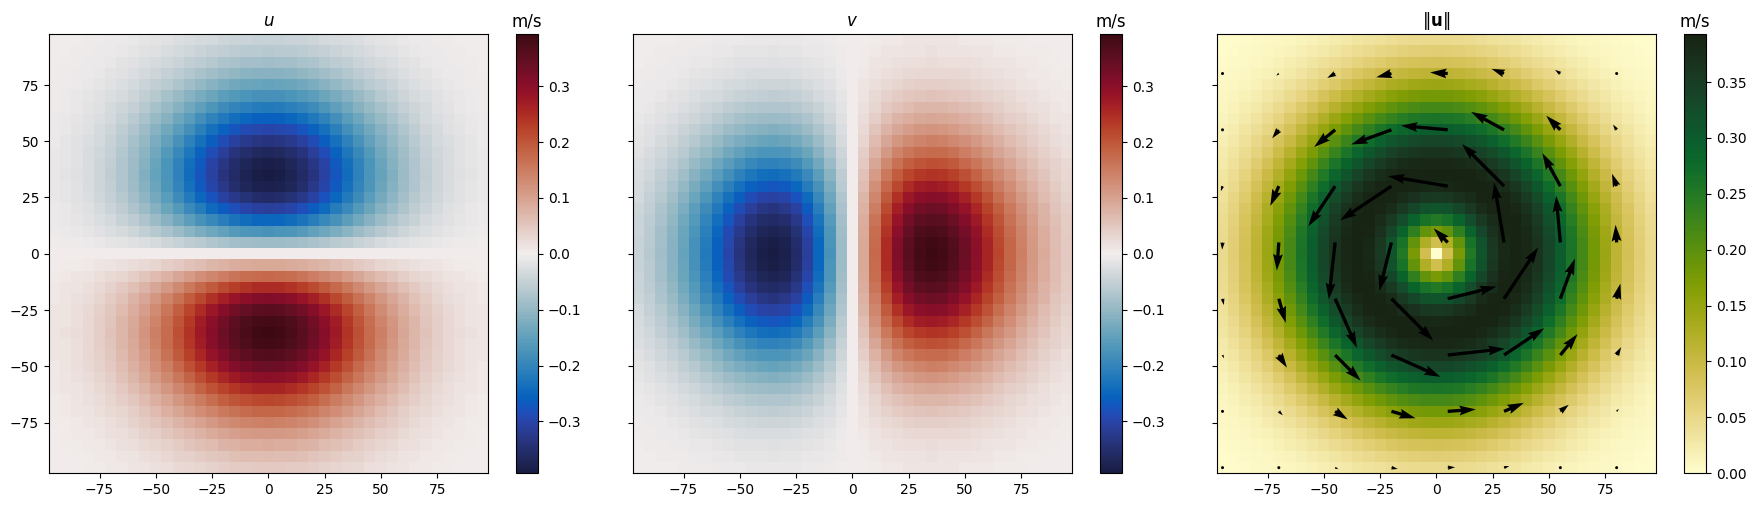

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

ax1.set_title("$u$")
im = ax1.pcolormesh(X / 1e3, Y / 1e3, u_geos_t, cmap=cmo.balance)
ax1.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_title("m/s")

ax2.set_title("$v$")
im = ax2.pcolormesh(X / 1e3, Y / 1e3, v_geos_t, cmap=cmo.balance)
ax2.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax2)
cbar.ax.set_title("m/s")

ax3.set_title("$\| \mathbf{u} \|$")
im = ax3.pcolormesh(X / 1e3, Y / 1e3, uv_geos, cmap=cmo.speed)
ax3.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax3)
cbar.ax.set_title("m/s")
ax3.quiver(X[::5, ::5] / 1e3, Y[::5, ::5] / 1e3, u_geos_t[::5, ::5], v_geos_t[::5, ::5], color="k")

fig.tight_layout()

plt.show()

### Numerical solution

$f\mathbf{k} \times \mathbf{u_g} = -g \nabla \eta$

In [9]:
u_geos_est, v_geos_est = _geostrophy(ssh, dXY, dXY, coriolis_factor, mask)

u_geos_est_t = operators.interpolation(u_geos_est, mask, axis=1, padding="left")
v_geos_est_t = operators.interpolation(v_geos_est, mask, axis=0, padding="left")

u_geos_est_t = u_geos_est_t.at[(0, -1), :].set(jnp.nan)
u_geos_est_t = u_geos_est_t.at[:, (0, -1)].set(jnp.nan)
v_geos_est_t = v_geos_est_t.at[(0, -1), :].set(jnp.nan)
v_geos_est_t = v_geos_est_t.at[:, (0, -1)].set(jnp.nan)

uv_geos_est = kinematics.magnitude(u_geos_est_t, v_geos_est_t, interpolate=False)
geos_diff = uv_geos_est - uv_geos

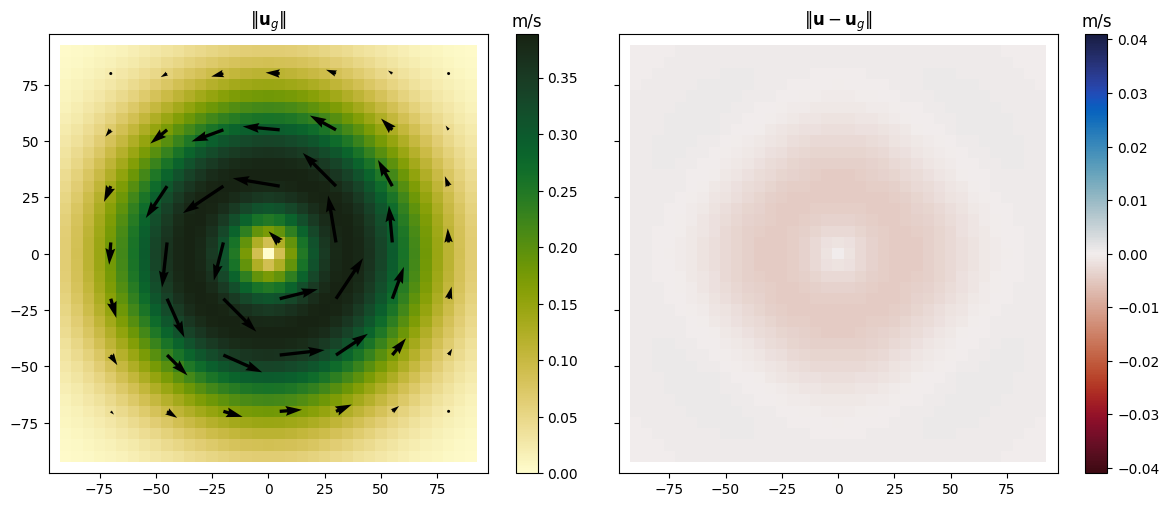

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
ax1, ax2 = axes.flatten()

ax1.set_title("$\| \mathbf{u}_g \|$")
im = ax1.pcolormesh(X / 1e3, Y / 1e3, uv_geos_est, cmap=cmo.speed)
ax1.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_title("m/s")
ax1.quiver(X[::5, ::5] / 1e3, Y[::5, ::5] / 1e3, u_geos_est_t[::5, ::5], v_geos_est_t[::5, ::5], color="k")

ax2.set_title("$\| \mathbf{u} - \mathbf{u}_g \|$")
im = ax2.pcolormesh(X / 1e3, Y / 1e3, geos_diff, cmap=cmo.balance_r, vmax=0.041, vmin=-0.041)
ax2.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax2)
cbar.ax.set_title("m/s")

fig.tight_layout()

plt.show()

## Cyclogeostrophy

### Analytical - gradient wind solution

$V_{gr}=\frac{2V_g}{1+\sqrt{1+4V_g/(fr)}}$

$u_{gr} = -V_{gr} \frac{y}{r}$

$v_{gr} = V_{gr} \frac{x}{r}$

In [11]:
uv_cyclo = kinematics.magnitude(u_cyclo_t, v_cyclo_t, interpolate=False)

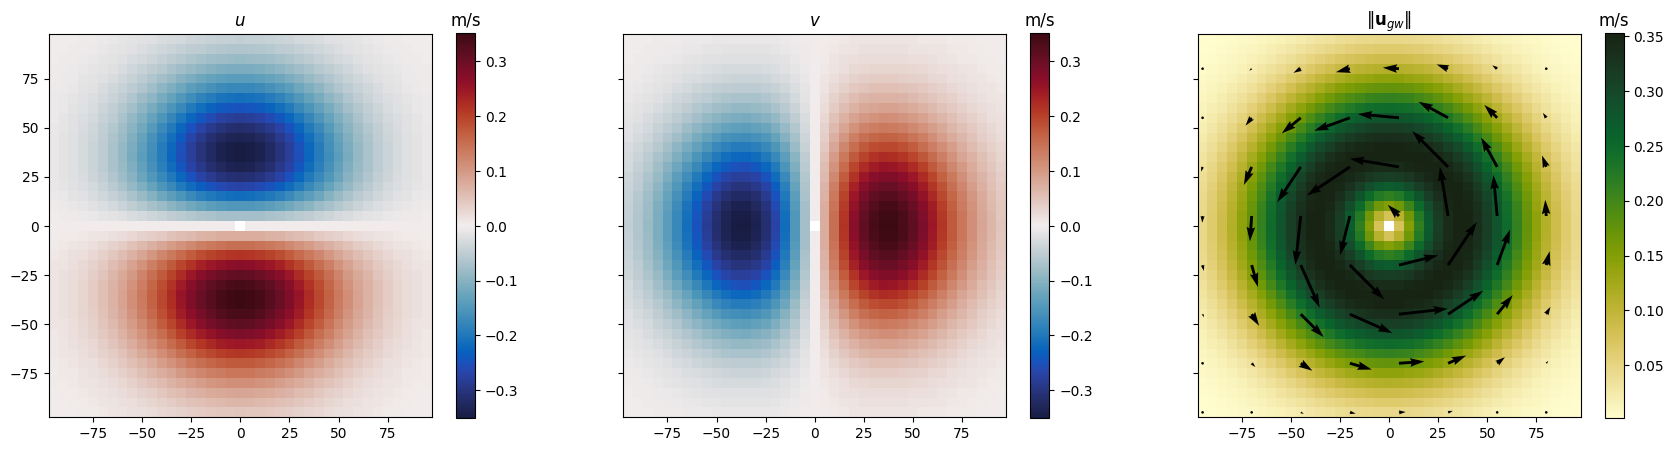

In [12]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5), sharex=True, sharey=True)

ax1.set_title("$u$")
im = ax1.pcolormesh(X / 1e3, Y / 1e3, u_cyclo_t, cmap=cmo.balance)
ax1.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_title("m/s")

ax2.set_title("$v$")
im = ax2.pcolormesh(X / 1e3, Y / 1e3, v_cyclo_t, cmap=cmo.balance)
ax2.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax2)
cbar.ax.set_title("m/s")

ax3.set_title("$\| \mathbf{u}_{gw} \|$")
im = ax3.pcolormesh(X / 1e3, Y / 1e3, uv_cyclo, cmap=cmo.speed)
ax3.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax3)
cbar.ax.set_title("m/s")
ax3.quiver(X[::5, ::5] / 1e3, Y[::5, ::5] / 1e3, u_cyclo_t[::5, ::5], v_cyclo_t[::5, ::5], color="k")

fig.tight_layout()

plt.show()

### Numerical solutions

#### Geostrophic estimation

$f\mathbf{k} \times \mathbf{u_g} = -g \nabla \eta$

In [13]:
geos_diff = uv_geos_est - uv_cyclo

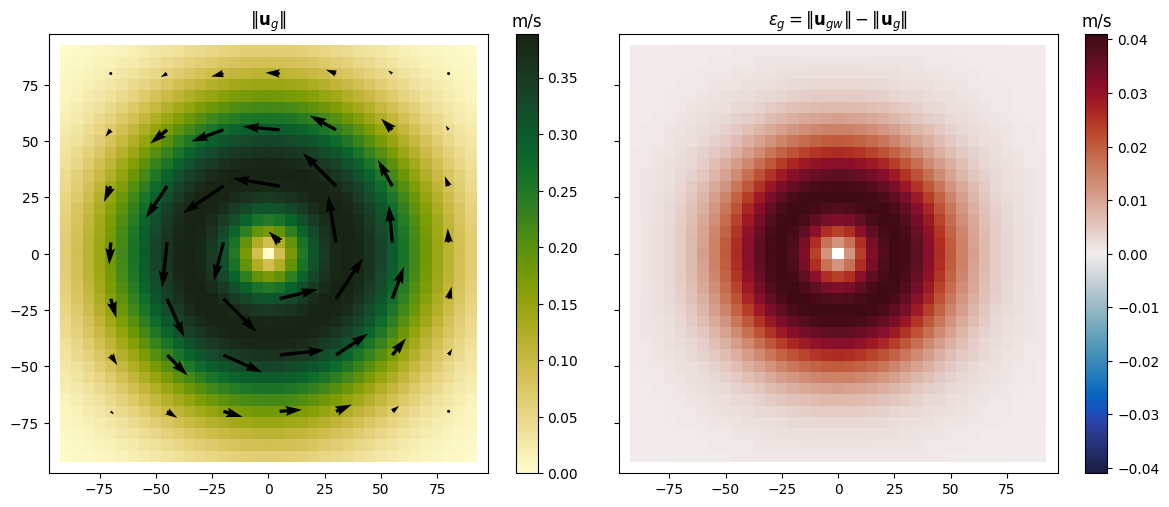

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
ax1, ax2 = axes.flatten()

ax1.set_title("$\| \mathbf{u}_g \|$")
im = ax1.pcolormesh(X / 1e3, Y / 1e3, uv_geos_est, cmap=cmo.speed)
ax1.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_title("m/s")
ax1.quiver(X[::5, ::5] / 1e3, Y[::5, ::5] / 1e3, u_geos_est_t[::5, ::5], v_geos_est_t[::5, ::5], color="k")

ax2.set_title("$\\varepsilon_g = \| \mathbf{u}_{gw} \| - \| \mathbf{u}_g \|$")
im = ax2.pcolormesh(X / 1e3, Y / 1e3, geos_diff, cmap=cmo.balance, vmax=0.041, vmin=-0.041)
ax2.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax2)
cbar.ax.set_title("m/s")

fig.tight_layout()

plt.show()

In [15]:
u_geos_u = u_geos_est
v_geos_v = v_geos_est
mask = sanitize.init_land_mask(u_geos_t)

#### Minimization-based estimation

$\mathbf{u} - \frac{\mathbf{k}}{f} \times (\mathbf{u} \cdot \nabla \mathbf{u}) = \mathbf{u_g}$

$\mathbf{u}_{cg,MB} = \arg \min_{\mathbf{u}} \| \mathbf{u} - \mathbf{u_g} - \frac{\mathbf{k}}{f} \times (\mathbf{u} \cdot \nabla \mathbf{u}) \|$

In [16]:
optim = optax.sgd(5e-2)
u_cyclo_est, v_cyclo_est, _ = _minimization_based(u_geos_u, v_geos_v, dXY, dXY, dXY, dXY,
                                           coriolis_factor, coriolis_factor, mask,
                                           n_it=20, optim=optim)

u_cyclo_est_t = operators.interpolation(u_cyclo_est, mask, axis=1, padding="left")
v_cyclo_est_t = operators.interpolation(v_cyclo_est, mask, axis=0, padding="left")

u_cyclo_est_t = u_cyclo_est_t.at[(0, -1), :].set(jnp.nan)
u_cyclo_est_t = u_cyclo_est_t.at[:, (0, -1)].set(jnp.nan)
v_cyclo_est_t = v_cyclo_est_t.at[(0, -1), :].set(jnp.nan)
v_cyclo_est_t = v_cyclo_est_t.at[:, (0, -1)].set(jnp.nan)

uv_cyclo_est = kinematics.magnitude(u_cyclo_est_t, v_cyclo_est_t, interpolate=False)
cyclo_diff = uv_cyclo_est - uv_cyclo
cyclo_imp = jnp.abs(geos_diff) - jnp.abs(cyclo_diff)

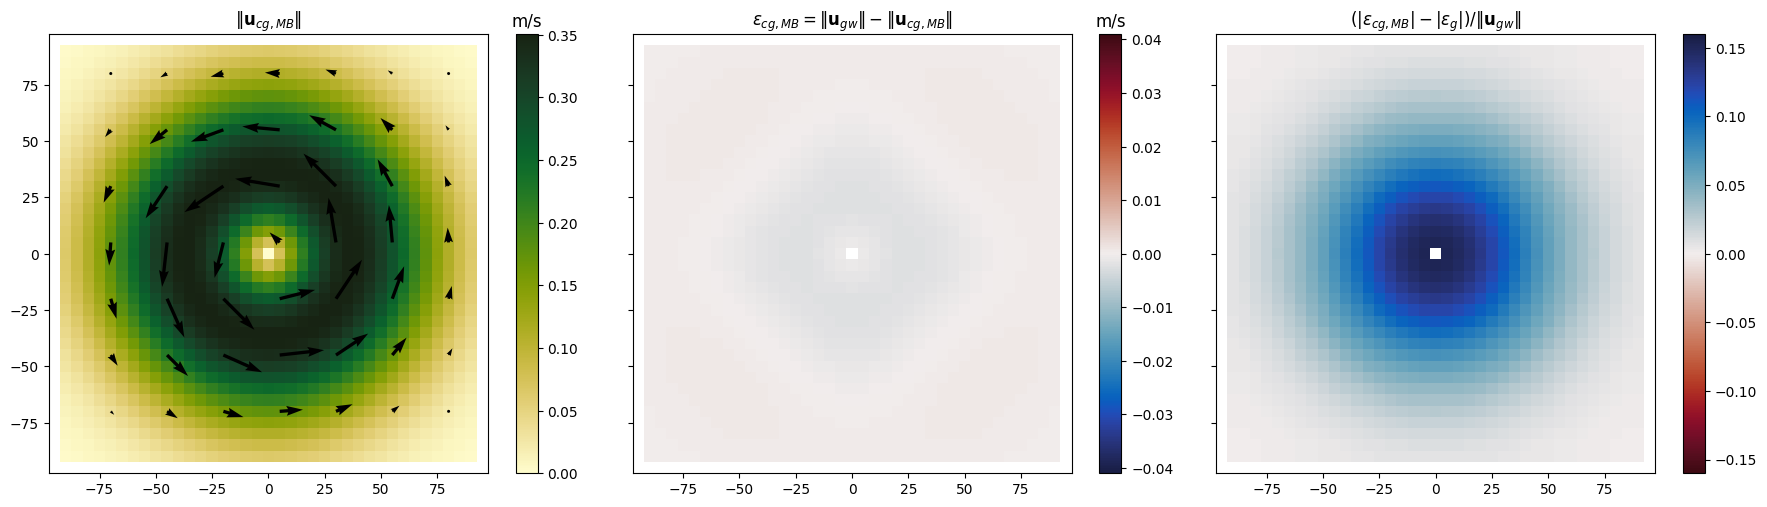

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
ax1, ax2, ax3 = axes.flatten()

ax1.set_title("$\| \mathbf{u}_{cg,MB} \|$")
im = ax1.pcolormesh(X / 1e3, Y / 1e3, uv_cyclo_est, cmap=cmo.speed)
ax1.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_title("m/s")
ax1.quiver(X[::5, ::5] / 1e3, Y[::5, ::5] / 1e3, u_cyclo_est_t[::5, ::5], v_cyclo_est_t[::5, ::5], color="k")


ax2.set_title("$\\varepsilon_{cg,MB} = \| \mathbf{u}_{gw} \| - \| \mathbf{u}_{cg,MB} \|$")
im = ax2.pcolormesh(X / 1e3, Y / 1e3, cyclo_diff, cmap=cmo.balance, vmax=0.041, vmin=-0.041)
ax2.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax2)
cbar.ax.set_title("m/s")

ax3.set_title("$(|\\varepsilon_{cg,MB}| - |\\varepsilon_g|) / \| \mathbf{u}_{gw} \|$")
im = ax3.pcolormesh(X / 1e3, Y / 1e3, cyclo_imp / uv_cyclo, cmap=cmo.balance_r, vmax=0.16, vmin=-0.16)
ax3.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax3)

fig.tight_layout()

plt.show()

#### Fixed-point estimation

$\mathbf{u} - \frac{\mathbf{k}}{f} \times (\mathbf{u} \cdot \nabla \mathbf{u}) = \mathbf{u_g}$

$\mathbf{u}^{(n+1)} = \mathbf{u_g} + \frac{\mathbf{k}}{f} \times (\mathbf{u}^{(n)} \cdot \nabla \mathbf{u}^{(n)})$

In [18]:
u_cyclo_est, v_cyclo_est, _ = _fixed_point(u_geos_u, v_geos_v, dXY, dXY, dXY, dXY,
                                         coriolis_factor, coriolis_factor, mask,
                                         n_it=20, res_eps=0.01,
                                         use_res_filter=False, res_filter_size=1, 
                                         return_losses=False)

u_cyclo_est_t = operators.interpolation(u_cyclo_est, mask, axis=1, padding="left")
v_cyclo_est_t = operators.interpolation(v_cyclo_est, mask, axis=0, padding="left")

u_cyclo_est_t = u_cyclo_est_t.at[(0, -1), :].set(jnp.nan)
u_cyclo_est_t = u_cyclo_est_t.at[:, (0, -1)].set(jnp.nan)
v_cyclo_est_t = v_cyclo_est_t.at[(0, -1), :].set(jnp.nan)
v_cyclo_est_t = v_cyclo_est_t.at[:, (0, -1)].set(jnp.nan)

uv_cyclo_est = kinematics.magnitude(u_cyclo_est_t, v_cyclo_est_t, interpolate=False)
cyclo_diff = uv_cyclo_est - uv_cyclo
cyclo_imp = jnp.abs(geos_diff) - jnp.abs(cyclo_diff)

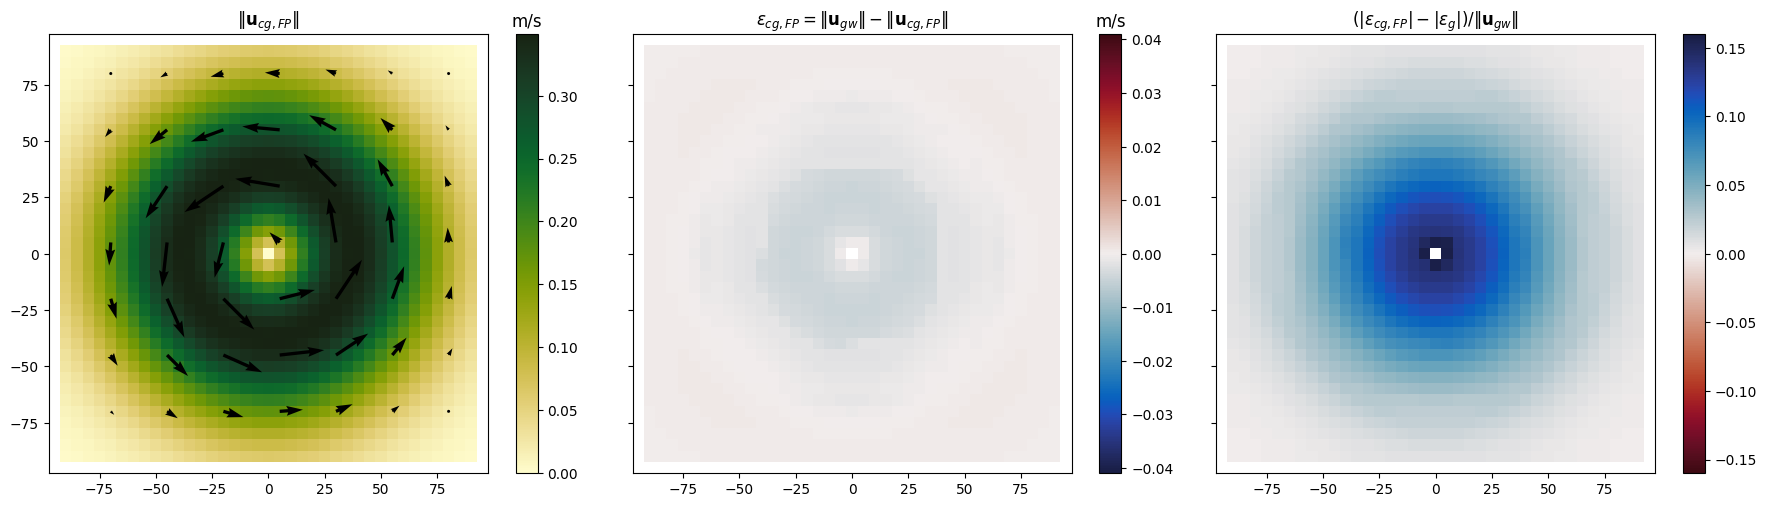

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
ax1, ax2, ax3 = axes.flatten()

ax1.set_title("$\| \mathbf{u}_{cg,FP} \|$")
im = ax1.pcolormesh(X / 1e3, Y / 1e3, uv_cyclo_est, cmap=cmo.speed)
ax1.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax1)
cbar.ax.set_title("m/s")
ax1.quiver(X[::5, ::5] / 1e3, Y[::5, ::5] / 1e3, u_cyclo_est_t[::5, ::5], v_cyclo_est_t[::5, ::5], color="k")

ax2.set_title("$\\varepsilon_{cg,FP} = \| \mathbf{u}_{gw} \| - \| \mathbf{u}_{cg,FP} \|$")
im = ax2.pcolormesh(X / 1e3, Y / 1e3, cyclo_diff, cmap=cmo.balance, vmax=0.041, vmin=-0.041)
ax2.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax2)
cbar.ax.set_title("m/s")

ax3.set_title("$(|\\varepsilon_{cg,FP}| - |\\varepsilon_g|) / \| \mathbf{u}_{gw} \|$")
im = ax3.pcolormesh(X / 1e3, Y / 1e3, cyclo_imp / uv_cyclo, cmap=cmo.balance_r, vmax=0.16, vmin=-0.16)
ax3.set_aspect("equal")
cbar = plt.colorbar(im, ax=ax3)

fig.tight_layout()

plt.show()